# Run and process the prior monte carlo and pick a "truth" realization

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

flopy is installed in /Users/jeremyw/Dev/flopy/flopy


In [2]:
t_d = "template"
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))

### run the prior ensemble in parallel locally

In [3]:
m_d = "master_prior_sweep"
#pyemu.os_utils.start_slaves(t_d,"pestpp-swp","freyberg.pst",num_slaves=20,slave_root=".",master_dir=m_d)

### Load the output ensemble and plot a few things

The observations with the `fa_hw` tag are "flow aquifer" outputs from the SFR ASCII output file and the `hw` is for the "headwaters" cumulative flow aquifer for the upper 20 reaches

In [4]:
obs = pst.observation_data
swgw = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
swgw

obsnme
fa_hw_19791230    fa_hw_19791230
fa_hw_19801229    fa_hw_19801229
Name: obsnme, dtype: object

Two forecasts - one during the historical period, and one during the scenario period

In [5]:
obs_df = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
obs_df.shape

(200, 4461)

drop any failed runs

In [6]:
obs_df = obs_df.loc[obs_df.failed_flag==0,:]
obs_df.shape

(200, 4461)

In [7]:
#obs_df.phi.apply(np.log10).hist(bins=20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x182168f6d8>,
      dtype=object)

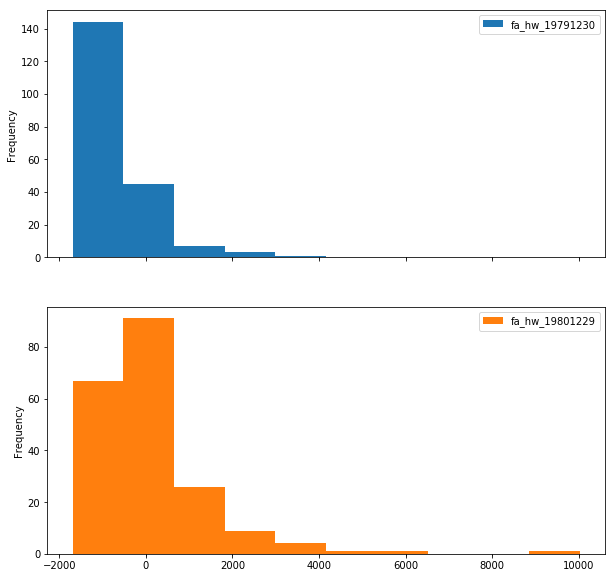

In [8]:
obs_df.loc[:,swgw].plot(kind="hist",subplots=True,figsize=(10,10))

We see that under scenario conditions, many more realizations for the flow to the aquifer in the headwaters are postive (as expected).  Lets difference these two:

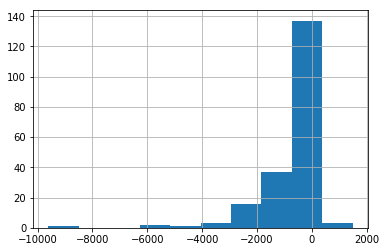

In [9]:
diff = obs_df.loc[:,swgw[0]] - obs_df.loc[:,swgw[1]]
diff.hist()

We now see that the most extreme scenario yields a large decrease in flow from the aquifer to the headwaters (the most negative value)

In [10]:
diff_sort = diff.sort_values()
diff_sort.head()

run_id
50    -9605.04466
91    -6126.15271
137   -5455.38553
63    -4177.61906
173   -3625.20490
dtype: float64

We just need to replace the observed values (`obsval`) in the control file with the outputs for one of the realizations on `obs_df`.  In this way, we now have the nonzero values for history matching, but also the ``truth`` values for comparing how we are doing with other unobserved quantities.  Im going to pick a realization that yields an "average" variability of the observed gw levels:

In [11]:
std_obs = obs_df.loc[:,pst.nnz_obs_names].std(axis=1).sort_values()
idx = std_obs.index[int(obs_df.shape[0]/2)]

In [12]:
obs_df.loc[idx,pst.nnz_obs_names]

hds_00_002_009_000    36.955250
hds_00_002_015_000    34.576363
hds_00_003_008_000    36.992844
hds_00_009_001_000    38.792450
hds_00_013_010_000    35.291306
hds_00_015_016_000    34.760986
hds_00_021_010_000    35.167488
hds_00_022_015_000    34.573235
hds_00_024_004_000    36.454193
hds_00_026_006_000    35.657467
hds_00_029_015_000    34.325661
hds_00_033_007_000    34.909630
hds_00_034_010_000    34.169098
Name: 120, dtype: float64

Lets see how our selected truth does with the swgw forecasts:

In [13]:
print(obs_df.loc[idx,swgw])
print(diff_sort.loc[idx])

fa_hw_19791230   -641.5985
fa_hw_19801229     46.7631
Name: 120, dtype: float64
-688.3616


In [14]:
pst.observation_data.loc[:,"obsval"] = obs_df.loc[idx,pst.obs_names]
pst.observation_data.loc[pst.nnz_obs_names,"weight"] = 10.0

Now, it is custom to add noise to the observed values...we will use the classic Gaussian noise...zero mean and standard deviation of 1 over the weight

In [15]:
# np.random.seed = 0
# print(np.random.seed)
# std = 1.0 / pst.observation_data.loc[pst.nnz_obs_names,"weight"].mean()
# noise = np.random.normal(0,std,size=pst.nnz_obs)
# pst.observation_data.loc[pst.nnz_obs_names,"obsval"] += noise

In [16]:
pst.write(os.path.join(t_d,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=t_d)

In [17]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

133.02210727406347


,name,group,measured,modelled,residual,weight
name,,,,,,
hds_00_002_009_000,hds_00_002_009_000,calhead,36.955250,37.107498,-0.152248,10.0
hds_00_002_015_000,hds_00_002_015_000,calhead,34.576363,35.045185,-0.468822,10.0
hds_00_003_008_000,hds_00_003_008_000,calhead,36.992844,37.397289,-0.404446,10.0
hds_00_009_001_000,hds_00_009_001_000,calhead,38.792450,39.546417,-0.753967,10.0
hds_00_013_010_000,hds_00_013_010_000,calhead,35.291306,35.571774,-0.280468,10.0
hds_00_015_016_000,hds_00_015_016_000,calhead,34.760986,34.835716,-0.074730,10.0
hds_00_021_010_000,hds_00_021_010_000,calhead,35.167488,35.386250,-0.218761,10.0
hds_00_022_015_000,hds_00_022_015_000,calhead,34.573235,34.577492,-0.004257,10.0
hds_00_024_004_000,hds_00_024_004_000,calhead,36.454193,36.760464,-0.306271,10.0


Just to make sure we have everything working right, we should be able to load the truth parameters, run the model once and have a (near-)zero `phi`:

In [18]:
par_df = pd.read_csv(os.path.join(m_d,"sweep_in.csv"),index_col=0)
pst.parameter_data.loc[:,"parval1"] = par_df.loc[idx,pst.par_names]
pst.write(os.path.join(m_d,"test.pst"))
pyemu.os_utils.run("pestpp-ies.exe test.pst",cwd=m_d)

In [19]:
pst = pyemu.Pst(os.path.join(m_d,"test.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

8.71020783292314e-17


,name,group,measured,modelled,residual,weight
name,,,,,,
hds_00_002_009_000,hds_00_002_009_000,calhead,36.955250,36.955250,-3.769500e-10,10.0
hds_00_002_015_000,hds_00_002_015_000,calhead,34.576363,34.576363,1.367155e-10,10.0
hds_00_003_008_000,hds_00_003_008_000,calhead,36.992844,36.992844,7.031531e-11,10.0
hds_00_009_001_000,hds_00_009_001_000,calhead,38.792450,38.792450,-1.718732e-10,10.0
hds_00_013_010_000,hds_00_013_010_000,calhead,35.291306,35.291306,7.815970e-12,10.0
hds_00_015_016_000,hds_00_015_016_000,calhead,34.760986,34.760986,-1.249987e-10,10.0
hds_00_021_010_000,hds_00_021_010_000,calhead,35.167488,35.167488,-1.445315e-10,10.0
hds_00_022_015_000,hds_00_022_015_000,calhead,34.573235,34.573235,-1.054659e-10,10.0
hds_00_024_004_000,hds_00_024_004_000,calhead,36.454193,36.454193,-2.343725e-10,10.0


In [21]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=m_d)

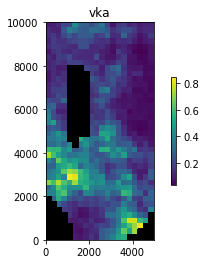

In [29]:
m.upw.vka[1].plot(colorbar=True)